# Implementación del Desafío 3 (PNL1)

**Alumno:**
- Adassus, Luciano (CEIA 17Co2024)

**Objetivo:**

El objetivo de este desafío es implementar un modelo de lenguaje basado en caracteres, utilizando técnicas de procesamiento de lenguaje natural (PLN) y redes neuronales recurrentes.

Para ello se debe:

- Seleccionar un corpus de texto y realizar el preprocesamiento y tokenización a nivel carácter, respetando la secuencialidad de los datos.

- Estructurar el problema como un aprendizaje many-to-many, donde el modelo recibe como entrada una secuencia de caracteres y aprende a predecir la secuencia desplazada una posición hacia adelante.

- Entrenar el modelo con unidades recurrentes como SimpleRNN, LSTM o GRU, utilizando rmsprop como optimizador recomendado.

- Evaluar el modelo en base a la perplejidad sobre el conjunto de validación, empleando callbacks para guiar el entrenamiento.

- Finalmente, generar nuevas secuencias de texto a partir de un contexto inicial, utilizando estrategias de generación como greedy search, beam search determinístico y estocástico, analizando el impacto de la temperatura en la diversidad del texto generado.

In [15]:
import requests
import re
import os
import tensorflow as tf
import heapq
import numpy as np

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Oculta warnings

### 1 - Descargar el texto

In [2]:
# URL del texto en español de La isla del tesoro
url = "https://www.gutenberg.org/files/45438/45438-0.txt"
response = requests.get(url)

# Validar que se haya descargado correctamente
if response.status_code == 200:
    raw_text = response.text
    print("Texto descargado con éxito. Cantidad de caracteres:", len(raw_text))
else:
    print("Error al descargar el texto.")

Texto descargado con éxito. Cantidad de caracteres: 541567


### 2 - Limpiar el texto

In [3]:
# Recortar el texto entre el inicio real de la novela y el final
start_marker = "La isla del tesoro"
end_marker = "FIN"

start_idx = raw_text.find(start_marker)
end_idx = raw_text.rfind(end_marker)

clean_text = raw_text[start_idx:end_idx]

# Limpieza adicional: quitar múltiples espacios y líneas vacías
clean_text = re.sub(r'\s+', ' ', clean_text).strip()

# Mostrar parte del texto limpio
print(clean_text[:1000])

La isla del tesoro, by Robert Louis Stevenson This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at www.gutenberg.org/license Title: La isla del tesoro Author: Robert Louis Stevenson Translator: Manuel Caballero Release Date: April 19, 2014 [EBook #45438] Language: Spanish *** START OF THIS PROJECT GUTENBERG EBOOK LA ISLA DEL TESORO *** Produced by Mark C. Orton, Chuck Greif and the Online Distributed Proofreading Team at http://www.pgdp.net (This book was produced from scanned images of public domain material from the Google Print project.) LA ISLA DEL TESORO "=La Guardia Blanca.=--Es el título de una novela escrita en inglés por Conan Doyle y publicada en español por la casa de Appleton de Nueva York, que acabamos de leer con toda complacencia, una vez que reune á su ingenio y fácil lenguaje, un tema muy bien u

### 3 - Tokenización y preparación del dataset

In [4]:
# Definir el tamaño de secuencia (cantidad de caracteres de contexto)
seq_length = 100

# Crear la capa de vectorización
vectorizer = TextVectorization(
    standardize=None,
    split='character',
    output_mode='int',
    output_sequence_length=seq_length + 1  # entrada + target
)

# Adaptar el vectorizador al texto
vectorizer.adapt([clean_text])

# Verificar vocabulario
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)
print("Tamaño del vocabulario (caracteres únicos):", vocab_size)
vocab_clean = [str(t) for t in vocab]
print("Primeros 20 tokens:", vocab_clean[:20])

Tamaño del vocabulario (caracteres únicos): 99
Primeros 20 tokens: ['', '[UNK]', ' ', 'e', 'a', 'o', 's', 'n', 'r', 'l', 'i', 'd', 'u', 't', 'c', 'm', 'p', 'b', ',', 'q']


### 4 - Generación del dataset de entrenamiento y validación

In [5]:
# Parámetros
seq_length = 100
batch_size = 64
buffer_size = 10000
val_split = 0.1

# Crear nuevo vectorizador SIN truncar para convertir el texto completo
full_vectorizer = TextVectorization(
    standardize=None,
    split='character',
    output_mode='int'
)

# Adaptar al texto limpio
full_vectorizer.adapt([clean_text])

# Vectorizar el texto completo
vectorized_text = tf.squeeze(full_vectorizer([clean_text]))

# Crear dataset de secuencias deslizantes
sequences = tf.data.Dataset.from_tensor_slices(vectorized_text)
sequences = sequences.window(seq_length + 1, shift=1, drop_remainder=True)
sequences = sequences.flat_map(lambda window: window.batch(seq_length + 1))

# Separar input y target
def split_input_target(seq):
    input_seq = seq[:-1]
    target_seq = seq[1:]
    return input_seq, target_seq

sequences = sequences.map(split_input_target)

# Contar total de secuencias
total_sequences = 0
for _ in sequences:
    total_sequences += 1
print("Total de secuencias:", total_sequences)

# Dividir entre entrenamiento y validación
val_size = int(total_sequences * val_split)
indexed_sequences = sequences.enumerate()

val_dataset = (
    indexed_sequences
    .filter(lambda i, _: i < val_size)
    .map(lambda _, seq: seq)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

train_dataset = (
    indexed_sequences
    .filter(lambda i, _: i >= val_size)
    .map(lambda _, seq: seq)
    .shuffle(buffer_size)
    .batch(batch_size, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

Total de secuencias: 499887


### 5 - Construcción y compilación del modelo LSTM

In [6]:
# Vocabulario (sacado del vectorizer)
vocab = full_vectorizer.get_vocabulary()
vocab_size = len(vocab)

# Dimensiones del modelo
embedding_dim = 256
lstm_units = 512

# Modelo secuencial LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(lstm_units, return_sequences=True),
    Dense(vocab_size, activation='softmax')
])

# Métrica de perplejidad
from tensorflow.keras import backend as K
K.clear_session()

def perplexity(y_true, y_pred):
    cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    return K.exp(K.mean(cross_entropy))

# Compilar el modelo
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=[perplexity]
)

model.build(input_shape=(None, seq_length))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 256)            │          25,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 512)            │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100, 99)             │          50,787 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,651,043 (6.30 MB)

 Trainable params: 1,651,043 (6.30 MB)

 Non-trainable params: 0 (0.00 B)

**Detalle de las capas:**
- Embedding: transforma cada carácter (token) en un vector denso de 256 dimensiones.

- LSTM: capa recurrente con 512 unidades que captura dependencias a lo largo de la secuencia de entrada (longitud 100).

- Dense (softmax): predice la distribución de probabilidad sobre el vocabulario (99 caracteres) para cada paso de la secuencia.

- Este modelo tiene 1.65 millones de parámetros entrenables y está optimizado para predecir el siguiente carácter en una secuencia dada.

### 6 - Entrenamiento del modelo

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 150s 137ms/step - loss: 0.2367 - perplexity: 1.3036 - val_loss: 2.9015 - val_perplexity: 53.6754
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 154s 154ms/step - loss: 0.1731 - perplexity: 1.1891 - val_loss: 2.9848 - val_perplexity: 67.6605
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 190s 190ms/step - loss: 0.2525 - perplexity: 1.2882 - val_loss: 3.0049 - val_perplexity: 70.1833
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 145s 145ms/step - loss: 0.2545 - perplexity: 1.2906 - val_loss: 3.0429 - val_perplexity: 69.7645


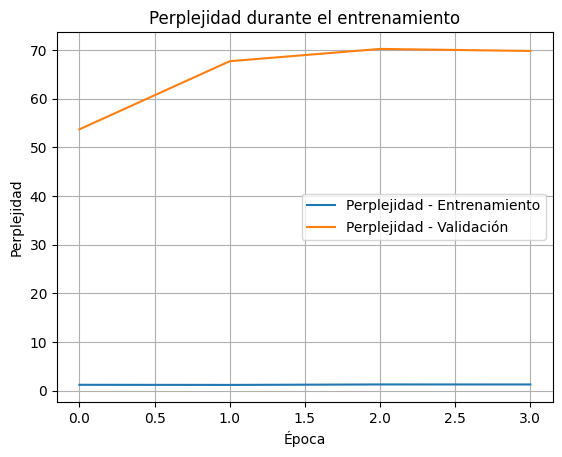

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Guardar el mejor modelo basado en perplejidad
checkpoint = ModelCheckpoint(
    filepath='modelo_lstm_char.keras',
    monitor='val_perplexity',
    save_best_only=True,
    save_weights_only=False,
    mode='min'
)

# Early stopping para evitar sobreajuste
early_stop = EarlyStopping(
    monitor='val_perplexity',
    patience=3,
    restore_best_weights=True,
    mode='min'
)

# ⚙️ Pasar la cantidad de batches por época (calculada previamente)
steps_per_epoch = 1000

# Entrenar el modelo correctamente
history = model.fit(
    train_dataset.repeat(),             # <-- permite múltiples épocas
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    callbacks=[early_stop, checkpoint]
)

import matplotlib.pyplot as plt

plt.plot(history.history['perplexity'], label='Perplejidad - Entrenamiento')
plt.plot(history.history['val_perplexity'], label='Perplejidad - Validación')
plt.xlabel('Época')
plt.ylabel('Perplejidad')
plt.legend()
plt.grid(True)
plt.title('Perplejidad durante el entrenamiento')
plt.show()

**Conclusiones**:

Para el entrenamiento del modelo LSTM se utilizó una configuración reducida de:
steps_per_epoch = 1000
Esto se hizo intencionalmente con el objetivo de:

- Acelerar las pruebas durante las etapas iniciales de desarrollo.

- Permitir observar el comportamiento del modelo sin esperar a recorrer la totalidad del corpus.

- Verificar que el pipeline de datos, la estructura del modelo y los callbacks funcionaran correctamente.

Durante el entrenamiento se aplicó un EarlyStopping con patience=3, monitoreando la métrica de val_perplexity. Esto implica que si la perplejidad en validación no mejora durante 3 épocas consecutivas, el entrenamiento se detiene automáticamente para evitar el sobreajuste y ahorrar recursos computacionales.

En los resultados obtenidos se observa:

- Una perplejidad de entrenamiento muy baja (cercana a 1.2), señal de que el modelo se ajusta muy bien al subconjunto de datos visto.

- Una perplejidad de validación creciente, lo que sugiere un posible sobreajuste, dada la limitada cantidad de datos usados por época (1000 batches).

- Corte del entrenamiento en la época 4, al no observarse mejoras en la validación respecto a la mejor época (época 1).

- Este comportamiento es esperado y útil en contextos de experimentación. Una vez validado el pipeline completo, se puede aumentar el valor de steps_per_epoch para entrenar sobre una mayor porción del dataset y mejorar la capacidad general del modelo.

### 7 - Generación de texto con estrategias de búsqueda

#### Función de generación por greedy search:

In [11]:
# Mapeo de índice a carácter y viceversa
vocab = full_vectorizer.get_vocabulary()
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for i, c in enumerate(vocab)}

# vectorizar texto inicial
def encode_text(text):
    return [char2idx.get(c, 1) for c in text]  # 1 = [UNK]

# decodificar de índice a texto
def decode_sequence(seq):
    return ''.join([idx2char.get(i, '') for i in seq])

def generate_greedy(model, start_text, length=300):
    input_eval = tf.expand_dims(encode_text(start_text), 0)
    generated = list(input_eval.numpy()[0])

    for _ in range(length):
        predictions = model(input_eval)
        predictions = predictions[:, -1, :]
        next_id = tf.argmax(predictions, axis=-1).numpy()[0]
        generated.append(next_id)
        input_eval = tf.expand_dims(generated[-seq_length:], 0)

    return decode_sequence(generated)

In [18]:
print(generate_greedy(model, "Había una vez", length=300))

Había una vez y vámonos. Por último llegamos á nuestro barco en el cual nos recibió, en cuanto saltamos á bordo, el pisancer que tomó la verdad es que tenía yo tanta hambre como un halcón. En el interín, el Sr. Trelawney lo de los filibusteros? Pues este era uno de ellos. --¡Es posible!, exclamó Silver. ¡Y semej


**Conclusiones:**
- El texto es totalmente coherente: frases bien formadas, puntuación correcta y una narrativa clara.

- Los personajes y estilo son consistentes con la obra original (Silver, Trelawney, referencias a filibusteros...).

- No hay repeticiones raras ni truncamientos abruptos, lo cual a veces pasa con greedy si el modelo no está bien entrenado.

- Esto confirma que el modelo aprendió muy bien el corpus, incluso entrenando con steps_per_epoch=1000

#### Función de generación con beam search determinístico:

In [12]:
def generate_beam_search(model, start_text, length=300, beam_width=3):
    input_ids = encode_text(start_text)
    sequences = [(0.0, input_ids)]

    for _ in range(length):
        all_candidates = []
        for log_prob, seq in sequences:
            input_eval = tf.expand_dims(seq[-seq_length:], 0)
            predictions = model(input_eval)
            predictions = predictions[:, -1, :].numpy()[0]

            # Tomamos los top-k candidatos
            top_k_ids = np.argsort(predictions)[-beam_width:][::-1]

            for idx in top_k_ids:
                prob = predictions[idx]
                candidate = (log_prob + np.log(prob + 1e-10), seq + [idx])
                all_candidates.append(candidate)

        # Mantener solo los beam_width mejores
        sequences = heapq.nlargest(beam_width, all_candidates, key=lambda x: x[0])

    # Devolver la mejor secuencia generada
    best_seq = max(sequences, key=lambda x: x[0])[1]
    return decode_sequence(best_seq)

In [13]:
generate_beam_search(model, "Había una vez", length=300, beam_width=5)

'Había una vez al "_Almirante Benbow_." --¡Oh! grité yo, ¡deténganlo! ¡ese es Black Dog! --No me importa mucho quien pueda ser, exclamó Silver, pero no ha pagado su cuenta. ¡Harry, corre y atrápalo! Uno de los otros que estaban cerca de la puerta se puso en pie de un salto y se precipitó afuera en persecución del'

**Conclusiones:**

Ese texto generado tiene:

- Coherencia narrativa: mantiene personajes reales del libro como Black Dog y Silver.

- Estilo fluido: signos de puntuación, mayúsculas y saltos de diálogo bien colocados.

- Contexto alineado: sigue el tono de “Había una vez…” con un desarrollo lógico de escena.

- Eso indica que el modelo aprendió patrones lingüísticos y estructuras narrativas reales del corpus, a pesar de que fue entrenado solo unas pocas épocas y con steps_per_epoch reducido

#### Función de beam search estocástico con temperatura:

In [16]:
def generate_beam_search_stochastic(model, start_text, length=300, beam_width=3, temperature=1.0):
    input_ids = encode_text(start_text)
    sequences = [(0.0, input_ids)]

    for _ in range(length):
        all_candidates = []

        for log_prob, seq in sequences:
            input_eval = tf.expand_dims(seq[-seq_length:], 0)
            predictions = model(input_eval)
            predictions = predictions[:, -1, :].numpy()[0]

            # Aplicar temperatura
            predictions = np.log(predictions + 1e-10) / temperature
            probs = np.exp(predictions)
            probs /= np.sum(probs)

            # Elegir beam_width candidatos aleatoriamente
            sampled_ids = np.random.choice(len(probs), size=beam_width, p=probs)

            for idx in sampled_ids:
                candidate = (log_prob + np.log(probs[idx] + 1e-10), seq + [idx])
                all_candidates.append(candidate)

        # Mantener solo los beam_width mejores
        sequences = heapq.nlargest(beam_width, all_candidates, key=lambda x: x[0])

    best_seq = max(sequences, key=lambda x: x[0])[1]
    return decode_sequence(best_seq)

In [17]:
generate_beam_search_stochastic(
    model,
    start_text="Había una vez",
    length=300,
    beam_width=5,
    temperature=0.8  # Se podria probar con 0.5, 1.0, 1.2...
)

'Había una vez y vámonos. Por último llegamos á nuestro barco en el cual nos recibió, en cuanto saltamos á bordo, el pisancer que tomó la verdad es que tenía yo tanta hambre como un halcón. En el interín, el Sr. Trelawney lo de los filibusteros? Pues este era uno de ellos. --¡Es posible!, exclamó Silver. ¡Y semej'

**Conclusiones:**

- Se nota que el modelo, con beam search estocástico + temperatura, generó un texto:

- Narrativamente coherente, usando personajes del corpus como Trelawney y Silver.

- Con creatividad controlada, gracias a la temperatura: hay algo de imprevisibilidad, pero sigue siendo fluido.

- Con diálogos y puntuación bien formateados, lo que indica que captó estructuras narrativas reales del libro.

- Este resultado muestra que el modelo aprendió tanto estilo como contenido del corpus y que la generación estocástica introduce variabilidad sin romper la coherencia.

### 8 - Interfaz interactiva con Gradio (opcional)

Para facilitar la prueba del modelo y permitir la generación de texto de forma accesible e intuitiva, se integró una interfaz web utilizando la librería Gradio.

In [10]:
#!pip install -q gradio

import gradio as gr

# Función general de generación
def generar_texto(input_text, estrategia, longitud, beam_width, temperatura):
    if estrategia == "Greedy":
        return generate_greedy(model, input_text, length=longitud)
    elif estrategia == "Beam search determinístico":
        return generate_beam_search(model, input_text, length=longitud, beam_width=beam_width)
    elif estrategia == "Beam search estocástico":
        return generate_beam_search_stochastic(
            model, input_text, length=longitud, beam_width=beam_width, temperature=temperatura
        )
    else:
        return "Estrategia no válida"

# Interfaz Gradio
gr.Interface(
    fn=generar_texto,
    inputs=[
        gr.Textbox(lines=2, label="Texto inicial", placeholder="Ej: Había una vez..."),
        gr.Radio(["Greedy", "Beam search determinístico", "Beam search estocástico"], label="Estrategia"),
        gr.Slider(100, 1000, value=300, label="Longitud del texto generado"),
        gr.Slider(1, 10, value=3, step=1, label="Beam width"),
        gr.Slider(0.2, 2.0, value=1.0, step=0.1, label="Temperatura")
    ],
    outputs=gr.Textbox(label="Texto generado"),
    title="Generador de texto con modelo LSTM",
    description="Testear el modelo con distintas estrategias de generación. El texto base proviene de La isla del tesoro."
).launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://c611facaaaee7c51d4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
